Load AAPL and MSFT daily price data with 20-day rolling mean & std of log returns

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = ['AAPL', 'MSFT']

raw = yf.download(tickers, period='1y', interval='1d', auto_adjust=True)

if isinstance(raw.columns, pd.MultiIndex):
    flat = raw.copy()
    flat.columns = [f"{tic}_{field.replace(' ', '')}" for field, tic in flat.columns]
else:  # single-ticker fallback
    t = tickers if isinstance(tickers, str) else tickers[0]
    flat = raw.add_prefix(f"{t}_")

# 3) Add returns (based on Close) for each ticker
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"]
else:
    prices = raw[["Close"]]
    t = tickers if isinstance(tickers, str) else tickers[0]
    prices.columns = [t]

simple = prices.pct_change()
log = np.log(prices).diff()
roll_mean20 = log.rolling(window=20, min_periods=20).mean()
roll_std20 = log.rolling(window=20, min_periods=20).std()

simple.columns = [f"{t}_simple_return" for t in simple.columns]
log.columns    = [f"{t}_log_return"    for t in log.columns]

roll_mean20.columns = [f"{t}_logret_sma20" for t in roll_mean20.columns]
roll_std20.columns  = [f"{t}_logret_std20" for t in roll_std20.columns]

# 4) Combine & save
df = pd.concat([flat, simple, log, roll_mean20, roll_std20], axis=1)
df.to_csv("tickers_full_1y.csv", index_label="date")
print("Saved tickers_full_1y.csv")

[*********************100%***********************]  2 of 2 completed

Saved tickers_full_1y.csv


Plot ACF and PACF of log returns

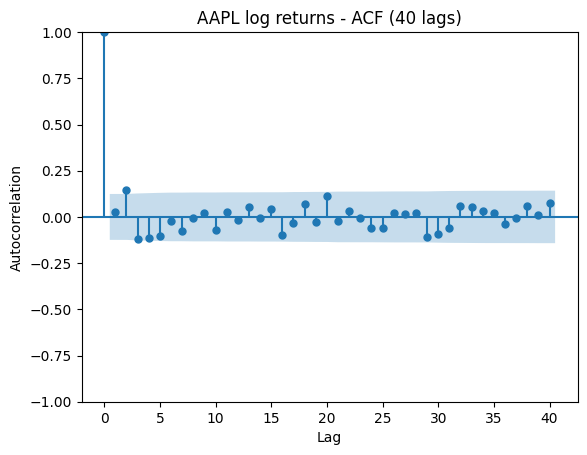

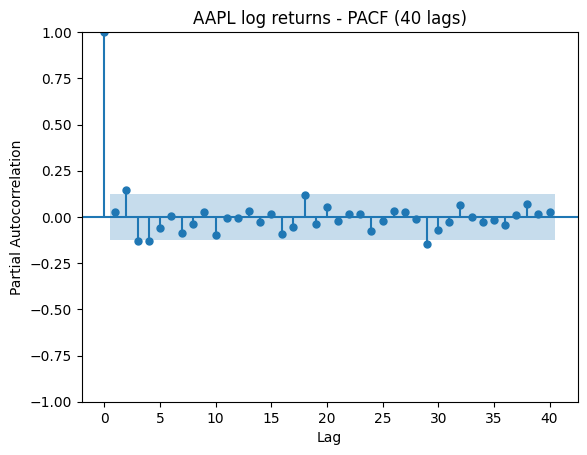

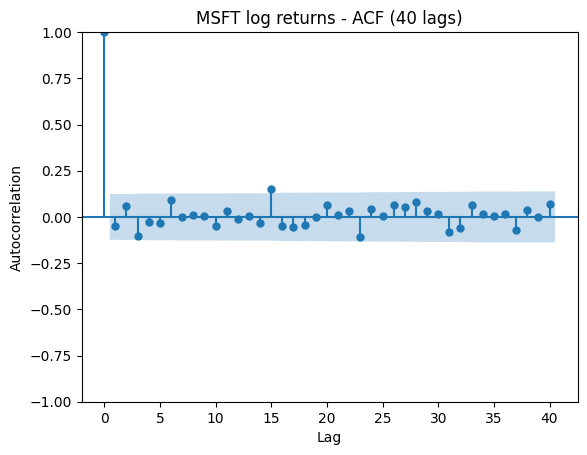

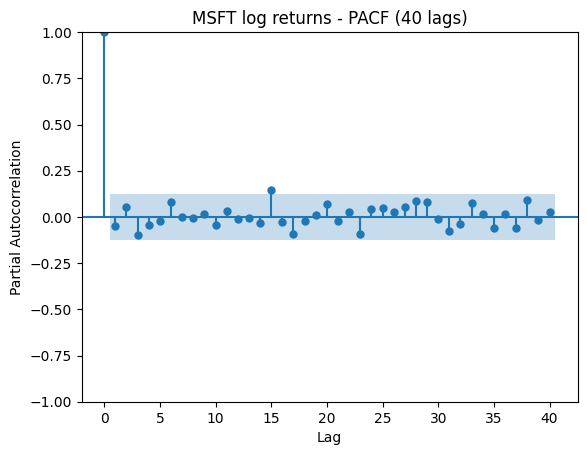

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

df_plot = pd.read_csv("tickers_full_1y.csv")

tickers = ["AAPL", "MSFT"]
nlags = 40 # number of lags, typical choice for daily data

for t in tickers:
    s = df[f"{t}_log_return"].dropna() # dropping nan values

    # For ACF
    plot_acf(s, lags=nlags)
    plt.title(f"{t} log returns - ACF ({nlags} lags)")
    plt.xlabel("Lag"); plt.ylabel("Autocorrelation")
    plt.show()


    # For PACF
    plot_pacf(s, lags=nlags, method="ywm") # using Yale-Walker modified
    plt.title(f"{t} log returns - PACF ({nlags} lags)")
    plt.xlabel("Lag"); plt.ylabel("Partial Autocorrelation")
    plt.show()

Performing the ADF test and interpreting the results

In [7]:
from statsmodels.tsa.stattools import adfuller
# we use the previous dataset for this too

def adf_on_series(s, regression="c", autolag="AIC", maxlag=None):
    """Run ADF and return a tidy dict of results"""

    s = s.dropna()
    stat, pval, usedlag, nobs, crit, icbest = adfuller(
        s, maxlag=maxlag, regression=regression, autolag=autolag
    )
    return {
        "test_stat": stat,
        "p_value": pval,
        "used_lag": usedlag,
        "nobs": nobs,
        "crit_1%": crit["1%"],
        "crit_5%": crit["5%"],
        "crit_10%": crit["10%"],
        "icbest": icbest,
        "regression": regression,
        "autolag": autolag,
    }

rows = []

for t in tickers:
    res = adf_on_series(df[f"{t}_log_return"])
    res["ticker"] = t
    rows.append(res)

adf_results = pd.DataFrame(rows).set_index("ticker")
adf_results.to_csv("adf_results_log_returns.csv")
print("ADF results saved to csv file")
print(adf_results)

# Immediate verdict
for t, r in adf_results.iterrows():
    verdict = (
        "Stationary (reject H0: unit root)"
        if (r["p_value"] < 0.05 and r["test_stat"] < r["crit_5%"])
        else "Non-stationary (fail to reject H0)"
    )
    print(f"{t}: {verdict} | p={r['p_value']:.3g}, stat={r['test_stat']:.3f}, 5% crit={r['crit_5%']:.3f}")

ADF results saved to csv file
        test_stat       p_value  used_lag  nobs   crit_1%   crit_5%  crit_10%  \
ticker                                                                          
AAPL    -8.973457  7.643025e-15         3   245 -3.457326 -2.873410 -2.573096   
MSFT   -16.486130  2.214111e-29         0   248 -3.456996 -2.873266 -2.573019   

             icbest regression autolag  
ticker                                  
AAPL   -1147.882720          c     AIC  
MSFT   -1262.210622          c     AIC  
AAPL: Stationary (reject H0: unit root) | p=7.64e-15, stat=-8.973, 5% crit=-2.873
MSFT: Stationary (reject H0: unit root) | p=2.21e-29, stat=-16.486, 5% crit=-2.873


Extra checks for if results are in fact stationary

In [9]:
import warnings
import pandas as pd
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model

tickers = ["AAPL", "MSFT"]

for t in tickers:
    s = df[f"{t}_log_return"].dropna()

    # KPSS (null: stationary). InterpolationWarning just means p-value is >= table max.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # suppress InterpolationWarning
        k_stat, k_p, _, _ = kpss(s, regression="c", nlags="auto")
    print(f"{t} KPSS: stat={k_stat:.3f}, p={k_p:.3g}")

    # Ljung–Box on returns (no autocorr expected for raw returns)
    lb = acorr_ljungbox(s, lags=[20], return_df=True)
    print(f"{t} Ljung–Box(20) p={lb['lb_pvalue'].iloc[-1]:.3g}")

    # ARCH LM (use nlags, not deprecated maxlag)
    arch_stat, arch_p, _, _ = het_arch(s, nlags=10)
    print(f"{t} ARCH LM(10) p={arch_p:.3g}\n")

# Example: GARCH(1,1) for AAPL
s = df["AAPL_log_return"].dropna()
am = arch_model(s * 100, mean="Constant", vol="GARCH", p=1, q=1, dist="t")  # scale to % for stability
res = am.fit(update_freq=0, disp="off")
print(res.summary())


AAPL KPSS: stat=0.068, p=0.1
AAPL Ljung–Box(20) p=0.109
AAPL ARCH LM(10) p=3.08e-06

MSFT KPSS: stat=0.220, p=0.1
MSFT Ljung–Box(20) p=0.627
MSFT ARCH LM(10) p=0.907

                        Constant Mean - GARCH Model Results                         
Dep. Variable:              AAPL_log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -465.684
Distribution:      Standardized Student's t   AIC:                           941.367
Method:                  Maximum Likelihood   BIC:                           958.955
                                              No. Observations:                  249
Date:                      Mon, Aug 18 2025   Df Residuals:                      248
Time:                              19:55:27   Df Model:                            1
                                 Mean Model                         